In [103]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.resnet_v2 import ResNet50V2 #to get pre-trained model ResNet
from keras.applications.resnet_v2 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm #to check loop progress
tqdm().pandas()

C:\Users\anand\AppData\Local\Temp\ipykernel_24584\1482682342.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [67]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [68]:
# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [69]:
#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [70]:
# build vocabulary of all unique words
def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [71]:
#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [72]:
#RelativePaths to dataset folders
dataset_text = 'Flickr8k_text'
dataset_images = 'Flicker8k_Dataset'

In [73]:
#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"

#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 descriptive text
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


In [74]:
#Feature extraction 
#extracting feature vector from all images
def extract_features(directory):
        model = ResNet50V2(include_top=False, pooling='avg')   
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((224,224))
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)
            feature = model.predict(image)
            features[img] = feature
        return features


In [76]:
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

C:\Users\anand\AppData\Local\Temp\ipykernel_24584\987730745.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm(os.listdir(directory)):


  0%|          | 0/8091 [00:00<?, ?it/s]

In [77]:
features = load(open("features.p","rb"))

In [78]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

In [79]:
# function to create a dictionary of all captions for an image
# also append start and end identifiers so that LSTM can identify start and end of our descriptive text
def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

In [80]:
#function to select only the required/needed features from all feature vectors
def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [81]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#preparing the training data
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [82]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [83]:
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary
from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [84]:
# tokenize the entire vocabulary, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1

#our vocabulary size
vocab_size

7577

In [85]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

In [86]:
max_length = max_length(descriptions)
max_length

32

In [87]:
# function to create input-output sequence pairs
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [88]:
#create input-output sequence pairs from the image description.
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            return [[input_image, input_sequence], output_word]

In [89]:
[a,b],c = data_generator(train_descriptions, features, tokenizer, max_length)
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

In [90]:
data = data_generator(train_descriptions, features, tokenizer, max_length)

In [91]:
data[0][0].shape

(47, 2048)

In [92]:
from tensorflow.keras.utils import plot_model

# define the descriptive model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [93]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 256)      1939712     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_5[0][0]      

In [94]:
print(model.input_shape)
model.input

[(None, 2048), (None, 32)]


[<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'input_5')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'input_6')>]

In [98]:
# making a directory models to save our models
#os.mkdir("models")

# training phase
#for i in range(1):
    #generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    #model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    #model.save("models/model_" + str(i) + ".h5")

In [99]:
def extract_features(filename, model):
    image = load_img(filename , target_size=(299, 299))
    image = img_to_array(image)
    if image.shape[2] == 4: 
            image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
        
def generate_desc(model, tokenizer, photo, max_length):
        in_text = "start"
        for i in range(max_length):
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)
            pred = model.predict([photo,sequence], verbose=0)
            pred = np.argmax(pred)
            word = word_for_id(pred, tokenizer)
            if word is None:
                break
            in_text += ' ' + word
            if word == 'end':
                break
        return in_text

In [111]:
tokenizer = load(open("tokenizer.pkl", 'rb'))
max_length = 34
model = load_model('models/model_9.h5')
path = 'images.jpg'
resnet_model = ResNet50V2(include_top=False, pooling="avg")
photo = extract_features(path, resnet_model)
description = generate_desc(model, tokenizer, photo, max_length)

Description of the image: man is walking on the beach


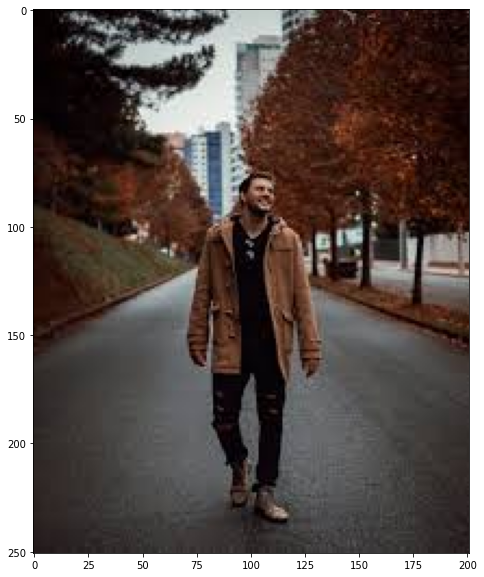

In [112]:
img = Image.open(path)
img = np.array(img)
plt.figure(figsize = (10, 10))
plt.imshow(img)

print("Description of the image: {}".format(' '.join(description.split()[1:-1])))